In [2]:
import torch
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from collections import defaultdict
import json
import sklearn
from sklearn.metrics import silhouette_samples

In [4]:
# Read in set of unique EC
ec_path = '/home/stef/hiec/data/ec.txt'
unique_ecs = {}
with open(ec_path, 'r') as f:
    temp = f.readlines()

temp = [elt[:-1] for elt in temp if ('B' not in elt) and (elt != '0.0.0.0\n')] # Remove newline, ecs w/ letters

for i in range(4):
    unique_ecs[i] = []
    
for elt in temp:
    for i in range(4):
        unique_ecs[i].append('.'.join(elt.split('.')[:i+1]))

temp = {}
for k,v in unique_ecs.items():
    temp[k] = sorted(list(set(v)))

unique_ecs = temp
for v in unique_ecs.values():
    print(len(v))


7
77
307
7830


In [5]:
directory = "/home/stef/hiec/data/embeddings/clean/" # "/home/stef/hiec/data/embeddings/esm1b/"
seed = 825
rng = np.random.default_rng(seed)

# Helpers
def save_json(data, save_to):
    with open(save_to, 'w') as f:
        json.dump(data, f)
    
def load_json(path):
    with open(path, 'r') as f:
        data = json.load(f)
    return data

def load_embed(path):
    path_split = path.split('/')
    if path_split[-2] == 'esm1b':
        model = torch.load(path)
        uni_id = model['label'].split(' | ')[0]
        ec = model['label'].split(' | ')[1]
        embed = model['mean_representations'][32]
    elif path_split[-2] == 'clean':
        uni_id, ec = path_split[-1].split(' | ')
        ec = ec[:-3] # Strip off '.pt'
        embed = torch.load(path)
    return uni_id, ec, embed

def load_class(ec, dir_path):
    '''Loads samples from
    provided EC class given 
    as an array or str'''
    if type(ec) == str:
        ec_str = '| ' + ec + '.'
    else:
        ec_str = '| ' + '.'.join([str(elt) for elt in ec]) + '.'
    
    ids, ecs, embeds = [], [], []
    for elt in os.listdir(dir_path):
        if ec_str in elt:
            path = dir_path + elt
            uni_id, this_ec, embed = load_embed(path)
            ids.append(uni_id)
            ecs.append(this_ec)
            embeds.append(embed)

    if len(embeds) > 0:
        embeds = torch.stack(embeds)

    return ids, ecs, embeds

def dist_between(vec, vec_arr):
    '''Computes Euclidean distance btwn
     vec and each row in vec_arr'''
    vec_repeat = np.tile(vec, (vec_arr.shape[0], 1))
    diff = vec_arr - vec_repeat
    dists = np.linalg.norm(diff, axis=1)
    return dists

def get_dmax(class_embeds):
    '''Computes maximum of distance
    from class centroid to each positive
    data point''' 
    centroid = np.mean(class_embeds, axis=0) # Compute class centroid
    ds_win_class = dist_between(centroid, class_embeds)
    dmax = np.max(ds_win_class).astype(float) # Get dmax
    return dmax

def dmax_error(class_embeds, neg_embeds, neg_ecs):
    '''Computes fraction of errors, negative samples
    contained within the hypersphere of radius dmax
    where dmax is the greatest distance between the class
    centroid and a positive sample''' 
    centroid = np.mean(class_embeds, axis=0) # Compute class centroid
    ds_win_class = dist_between(centroid, class_embeds)
    dmax = np.max(ds_win_class) # Get dmax
    ds_neg = dist_between(centroid, neg_embeds) # Distances from negative samples to class centroid
    less_dmax = ds_neg <= dmax
    fps = neg_embeds[np.array(less_dmax)] # "False positives" fall w/in hypersphere
    tns = neg_embeds[~np.array(less_dmax)] # "True negatives" fall outside of hypersphere
    fp_ecs = neg_ecs[np.array(less_dmax)] 
    tn_ecs = neg_ecs[~np.array(less_dmax)]
    error_frac = fp_ecs.shape[0] / neg_embeds.shape[0]
    # return error_frac, fps, tns, fp_ecs, tn_ecs
    return error_frac

In [ ]:
# Load embeds

n_levels = 4 # Levels of hierarchy in EC
class_ec = np.array([1,1,1]) # Class specifier. Maybe be of len 1 to n_levels
class_ec_ext = np.concatenate([class_ec, np.zeros(shape=(n_levels-len(class_ec)))]) # Extend class_ec w/ zeros
ids, class_ecs, class_embeds = load_class(class_ec, directory) # Load class
class_ecs = np.array([np.array(elt.split('.')).astype(int) for elt in class_ecs])
class_embeds = np.array(class_embeds)

# Load negative samples
neg_ecs = [] # ECs of negative samples (outside of class)
neg_embeds = []
for i, elt in enumerate(os.listdir(directory)[::10000]):
    _, this_ec, this_embed = load_embed(directory + elt)
    neg_ecs.append(np.array(this_ec.split('.')).astype(int)) # EC str -> arr
    neg_embeds.append(this_embed)

neg_embeds = np.vstack(neg_embeds)
neg_ecs = np.vstack(neg_ecs)

In [4]:
# Create dummy data

n_samples = 500
dim = 2 # Dimensionality of space
n_ints = 2 # Number of values a class digit can take
n_levels = 2 # Number of levels in class hierarchy
tot_labels = n_ints * n_levels

unique_labels = []
for i in range(1, n_levels + 1):
    for j in range(1, n_ints + 1):
        unique_labels.append((i, j))

# Random scattering, random labeling
random_data = rng.normal(size=(n_samples, dim))
random_labels = rng.choice(np.arange(n_ints)+1, size=(n_samples, n_levels))

# Hierarchical and non-hierarchical scatter
# Make ordered labels
n_per_class = n_samples // tot_labels
ordered_labels = []
for i in range(tot_labels):
    ordered_labels += [list(unique_labels[i]) for j in range(n_per_class)]

ordered_labels = np.array(ordered_labels)

cov = np.eye(2) # Define covariance

# Hierachical scatter
means = [[4, 8], [-4, 8], [-4, -8], [4, -8]]
hier_data = []
for i in range(tot_labels):
    hier_data.append(rng.multivariate_normal(means[i], cov, size=n_per_class))

hier_data = np.vstack(hier_data)


# Non-hierarchical scatter
means = [[4, 8], [-4, -8], [-4, 8], [4, -8]]
nh_data = []
for i in range(tot_labels):
    nh_data.append(rng.multivariate_normal(means[i], cov, size=n_per_class))

nh_data = np.vstack(nh_data)


In [197]:
# Select which dummy data and labels
dummy_data = random_data
dummy_labels = ordered_labels
class_ec = np.array([1,2]) # Select which class to specify, could be super class
class_ec_ext = np.concatenate([class_ec, np.zeros(shape=(n_levels-len(class_ec)))]) # Extend class_ec w/ zeros

# Split dummy data
# To get class samples, enforce that their EC number
# is the same as class_ec up to as long class_ec is
class_idx = np.sum(abs(dummy_labels - class_ec_ext)[:,:class_ec.shape[0]], axis=1) == 0
class_embeds = dummy_data[class_idx]
neg_embeds = dummy_data[~class_idx]
class_ecs = dummy_labels[class_idx]
neg_ecs = dummy_labels[~class_idx]

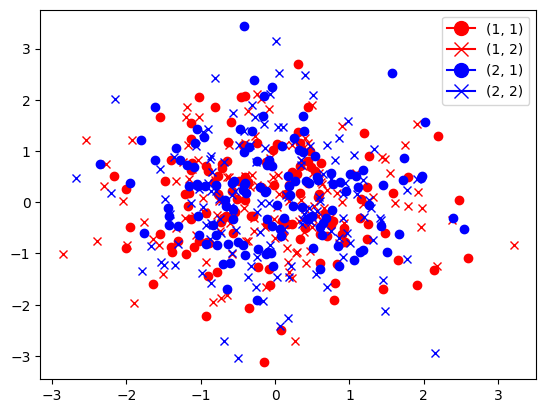

In [198]:
# Plot dummy data

fmt_strs = ['ro', 'rx', 'bo', 'bx']
leg_elts = []
for i in range(tot_labels):
    leg_elts.append(Line2D([0], [0], marker=fmt_strs[i][1], color=fmt_strs[i][0], label=unique_labels[i], markerfacecolor=fmt_strs[i][0], markersize=10))

fig, ax = plt.subplots()
for i in range(n_samples):
    idx = unique_labels.index(tuple(dummy_labels[i]))
    ax.plot(dummy_data[i][0], dummy_data[i][1], fmt_strs[idx])

ax.legend(handles=leg_elts)
plt.show()

In [132]:
# Compute error fraction for one class

centroid = np.mean(class_embeds, axis=0) # Compute class centroid
ds_win_class = dist_between(centroid, class_embeds)
dmax = np.max(ds_win_class) # Get dmax
ds_neg = dist_between(centroid, neg_embeds) # Distances from negative samples to class centroid
less_dmax = ds_neg <= dmax
fps = neg_embeds[np.array(less_dmax)] # "False positives" fall w/in hypersphere
tns = neg_embeds[~np.array(less_dmax)] # "True negatives" fall outside of hypersphere
fp_ecs = neg_ecs[np.array(less_dmax)] 
tn_ecs = neg_ecs[~np.array(less_dmax)]

# Keep track of order of error, i.e.,
# at what EC digit is there the first
# difference with the class ec
first_diff = lambda x : [list((x != 0)[i]).index(True) for i in range(x.shape[0])]
error_order = first_diff(fp_ecs - class_ec_ext)
error_frac = fp_ecs.shape[0] / neg_embeds.shape[0]
print(error_frac)

0.0


0.18307868870176752 0.0005172176724466508


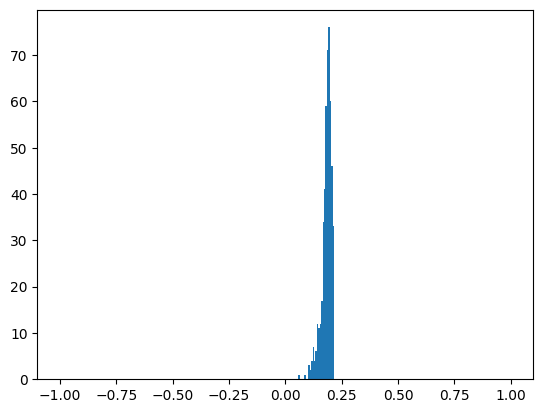

In [141]:
# Compute silhouette scores for one level

# Select which dummy data and labels
dummy_data = nh_data
dummy_labels = ordered_labels
sk_labels = [] # Integer labels
level = 1 # 1-indexed
ep = 1e-1

unique_level_labels = [tuple(elt[:level]) for elt in unique_labels] # Get unique labels up to level
dummy_level_labels = [tuple(elt[:level]) for elt in dummy_labels] # Get data labels up to level
for elt in dummy_level_labels:
    sk_labels.append(unique_level_labels.index(elt))

dummy_data.shape, dummy_labels.shape
sil_scores = silhouette_samples(dummy_data, sk_labels)
print(sil_scores.mean(), sil_scores.var())

fig, ax = plt.subplots()
ax.hist(sil_scores, bins=25)
ax.set_xlim(-1 - ep, 1 + ep)
plt.show()


In [199]:
# Loop over levels of label hierarchy
# and compute dmax error for dummy data

# Select which dummy data set and labels
dummy_data = random_data
dummy_labels = ordered_labels

unique_class_dict = {}
for j in range(n_levels):
    unique_class_dict[j] = set([tuple([elt[i] for i in range(j+1)]) for elt in unique_labels])

error_fracs = {}
for i in range(n_levels):
    error_fracs[i] = []
    for v in unique_class_dict[i]:
        class_ec = np.array(v) # Select which class to specify, could be super class
        class_ec_ext = np.concatenate([class_ec, np.zeros(shape=(n_levels-len(class_ec)))]) # Extend class_ec w/ zeros
        
        # Split dummy data
        # To get class samples, enforce that their EC number
        # is the same as class_ec up to as long class_ec is
        class_idx = np.sum(abs(dummy_labels - class_ec_ext)[:,:class_ec.shape[0]], axis=1) == 0
        class_embeds = dummy_data[class_idx]
        neg_embeds = dummy_data[~class_idx]
        class_ecs = dummy_labels[class_idx]
        neg_ecs = dummy_labels[~class_idx]

        error_fracs[i].append(dmax_error(class_embeds, neg_embeds, neg_ecs))

In [14]:
# Loop over levels of label hierarchy
# and compute dmax error for embeds

directory = "/home/stef/hiec/data/embeddings/clean/" # "/home/stef/hiec/data/embeddings/esm1b/"
n_levels = 4 # Levels of hierarchy in EC
do_shuffle = True
ds = 10 # Downsample factor

error_fracs = {}
dmaxes = {}
embed_idxs = defaultdict(lambda : defaultdict(list))

# Load embeddings
ecs = []
embeds = []
for i, elt in enumerate(os.listdir(directory)[::ds]):
    _, this_ec, this_embed = load_embed(directory + elt)
    ecs.append(np.array(this_ec.split('.')).astype(int)) # EC str -> arr
    embeds.append(this_embed)

    for j in range(n_levels):
        sub_key = '.'.join(this_ec.split('.')[:j+1])
        embed_idxs[j][sub_key].append(i)

embeds = np.vstack(embeds)
ecs = np.vstack(ecs)

# Shuffle data
if do_shuffle:
    rand_idxs = np.arange(embeds.shape[0])
    rng.shuffle(rand_idxs, axis=0) # Shuffle in place
    temp = embeds[rand_idxs]
    old_embeds = embeds
    embeds = temp


# Compute dmax errors
for i in range(n_levels):
    print(f"Level: {i+1}")
    error_fracs[i] = []
    dmaxes[i] = []
    for j in embed_idxs[i]:
        class_embeds = embeds[embed_idxs[i][j]]
        neg_embeds = np.delete(embeds, embed_idxs[i][j], axis=0)
        neg_ecs = np.delete(ecs, embed_idxs[i][j], axis=0)
        error_fracs[i].append(dmax_error(class_embeds, neg_embeds, neg_ecs))
        dmaxes[i].append(get_dmax(class_embeds))

Level: 1
Level: 2
Level: 3
Level: 4


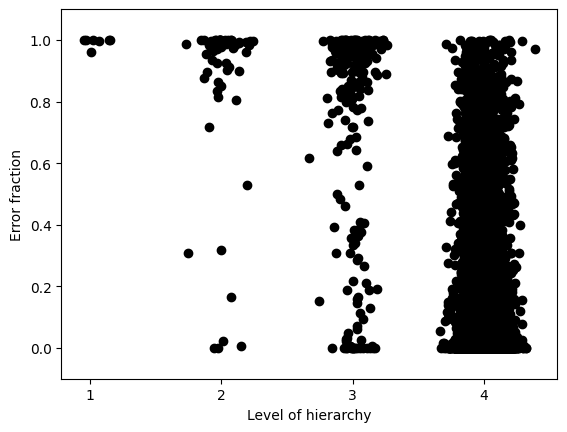

In [15]:
# Plot dmax error in scatter plot
ep = 1e-1
fig, ax = plt.subplots()
for k,v in error_fracs.items():
    ax.plot(np.ones_like(v) * k + rng.normal(0, 1e-1, size=len(v)), v, 'ko')

ax.set_xticks(list(error_fracs.keys()))
ax.set_xticklabels([k + 1 for k in error_fracs.keys()])
ax.set_ylabel('Error fraction')
ax.set_xlabel('Level of hierarchy')
ax.set_ylim(-ep, 1 + ep)
plt.show()

In [16]:
save_json(error_fracs, '../artifacts/dmax_error_fracs_clean_shuffled_ds_10.json')
save_json(dmaxes, '../artifacts/dmaxes_clean_shuffled_ds_10.json')

In [19]:
loaded_set = [load_json('../artifacts/dmaxes_clean_ds_10.json'),
                load_json('../artifacts/dmaxes_clean_shuffled_ds_10.json'),
                load_json('../artifacts/dmaxes_esm_ds_10.json'),
                load_json('../artifacts/dmaxes_esm_shuffled_ds_10.json')]

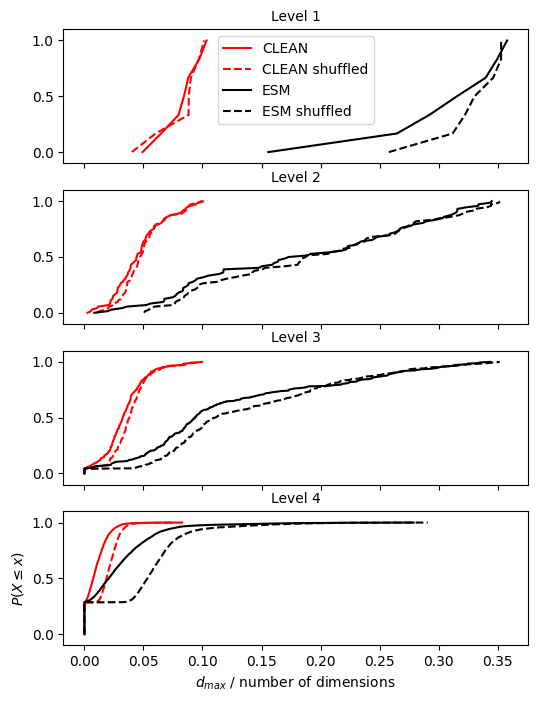

In [33]:
# Plot dmax error in cdfs
ep = 1e-1
fig, ax = plt.subplots(figsize=(6,8), nrows=n_levels, sharex=True, sharey=True)
colors = ['r', 'r', 'k', 'k']
linestyles = ['-', '--', '-', '--']
labels = ['CLEAN', 'CLEAN shuffled', 'ESM', 'ESM shuffled']
z = [128, 128, 1280, 1280] # n_dimensions

for j, elt in enumerate(loaded_set):
    for i,k in enumerate(elt.keys()):
        # x = np.sort(elt[k])
        x = np.sort(elt[k]) / z[j] # Normalize dmaxes by n_dimensions
        y = np.arange(len(x)) / (len(x) - 1)
        ax[i].plot(x, y, color=colors[j], label=labels[j], ls=linestyles[j])
        ax[i].set_title(f"Level {int(k)+1}", fontsize=10)

ax[-1].set_ylabel(r'$P(X \leq x)$')
ax[-1].set_xlabel(r'$d_{max}$ / number of dimensions')
# ax[-1].set_xlabel('Error frac')
ax[0].set_ylim(-ep, 1 + ep)
# ax[0].set_xlim(-ep, 1 + ep)
ax[0].legend()
plt.show()

In [174]:
# Loop over levels of label hierarchy
# and compute dmax error for embeds

directory = "/home/stef/hiec/data/embeddings/clean/" # "/home/stef/hiec/data/embeddings/esm1b/"
n_levels = 4 # Levels of hierarchy in EC
do_shuffle = False
ds = 1 # Downsample factor

# These lists have len=n_levels the entry at a given index corresponds to a level
unique_ec_tups = []
labels_by_level = [[] for i in range(n_levels)] # For actual ec tuples
sk_labels_by_level = [[] for i in range(n_levels)] # For integers corresponding to ecs
sil_scores = [] # For silhouette scores by level

# Create a list of lists of tups with unique ecs at each level
for k in unique_ecs.keys():
    unique_ec_tups.append([tuple(np.array(elt.split('.')).astype(int)) for elt in unique_ecs[k]])

# Load embeddings & their ec labels
ecs = []
embeds = []
for i, elt in enumerate(os.listdir(directory)[::ds]):
    _, this_ec, this_embed = load_embed(directory + elt)
    ecs.append(tuple(np.array(this_ec.split('.')).astype(int))) # EC str -> arr
    embeds.append(this_embed)

# Create a list of lists of embedding labels
for i, elt in enumerate(ecs):
    for j in range(n_levels):
        this_ec = ecs[i][:j+1]
        labels_by_level[j].append(this_ec)
        sk_labels_by_level[j].append(unique_ec_tups[j].index(this_ec))

embeds = np.vstack(embeds)
sk_labels_by_level = [np.array(elt) for elt in sk_labels_by_level]

# Shuffle data
if do_shuffle:
    rand_idxs = np.arange(embeds.shape[0])
    rng.shuffle(rand_idxs, axis=0) # Shuffle in place
    temp = embeds[rand_idxs]
    old_embeds = embeds
    embeds = temp

# Compute silhouette scores
for i in range(n_levels):
    sil_scores.append(silhouette_samples(embeds, sk_labels_by_level[i]))

In [175]:
fn = '/home/stef/hiec/artifacts/silhouette_clean.csv'
sil_scores = np.vstack(sil_scores)
np.savetxt(fn, sil_scores, delimiter=',')

In [176]:
fns = ['/home/stef/hiec/artifacts/silhouette_clean_ds_10.csv',
       '/home/stef/hiec/artifacts/silhouette_clean_shuffled_ds_10.csv',
       '/home/stef/hiec/artifacts/silhouette_esm1b_ds_10.csv',
       '/home/stef/hiec/artifacts/silhouette_esm1b_shuffled_ds_10.csv']

fns = ['/home/stef/hiec/artifacts/silhouette_clean.csv',
       ]
loaded_set = [np.loadtxt(fn, delimiter=',') for fn in fns]

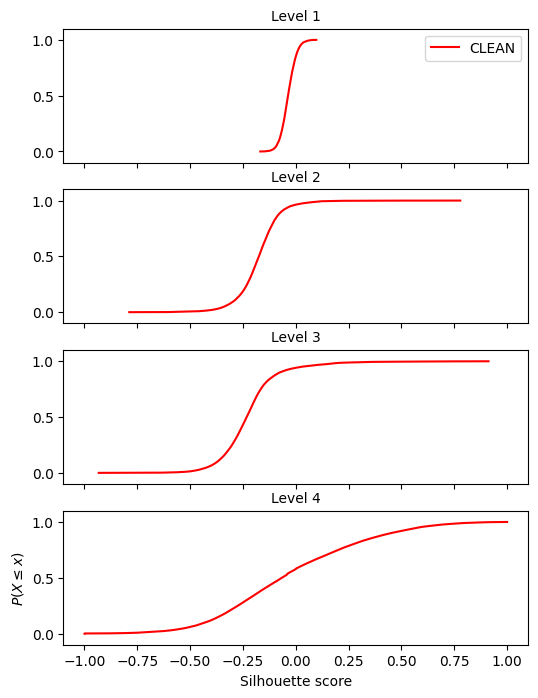

In [177]:
# Plot dmax error in cdfs
ep = 1e-1
fig, ax = plt.subplots(figsize=(6,8), nrows=n_levels, sharex=True, sharey=True)
colors = ['r', 'r', 'k', 'k']
linestyles = ['-', '--', '-', '--']
labels = ['CLEAN', 'CLEAN shuffled', 'ESM', 'ESM shuffled']

for j, elt in enumerate(loaded_set):
    for i, subelt in enumerate(elt):
        x = np.sort(subelt)
        y = np.arange(len(x)) / (len(x) - 1)
        ax[i].plot(x, y, color=colors[j], label=labels[j], ls=linestyles[j])
        ax[i].set_title(f"Level {int(i)+1}", fontsize=10)

ax[-1].set_ylabel(r'$P(X \leq x)$')
ax[-1].set_xlabel('Silhouette score')
ax[0].set_ylim(-ep, 1 + ep)
ax[0].set_xlim(-1 - ep, 1 + ep)
ax[0].legend()
plt.show()

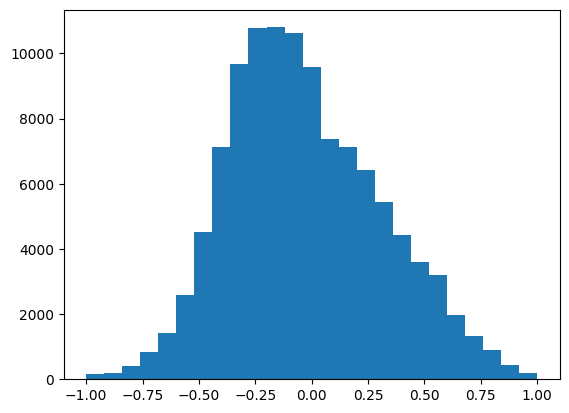

-0.027944863798451763


In [178]:
plt.hist(loaded_set[0][-1], bins=25)
plt.show()
print(loaded_set[0][-1].mean())

In [82]:
# Break out CLEAN errors by level

directory = "/home/stef/hiec/data/embeddings/clean/" # "/home/stef/hiec/data/embeddings/esm1b/"
n_levels = 4 # Levels of hierarchy in EC

# These lists have len=n_levels; the entry at a given index corresponds to a level
unique_ec_tups = []
labels_by_level = [[] for i in range(n_levels)] # For actual ec tuples
sk_labels_by_level = [[] for i in range(n_levels)] # For integers corresponding to ecs
sil_scores = [] # For silhouette scores by level

# Create a list of lists of tups with unique ecs at each level
for k in unique_ecs.keys():
    unique_ec_tups.append([tuple(np.array(elt.split('.')).astype(int)) for elt in unique_ecs[k]])

# Load embeddings & their ec labels
ecs = []
embeds = []
for i, elt in enumerate(os.listdir(directory)): # DO NOT ds here in general
    _, this_ec, this_embed = load_embed(directory + elt)
    ecs.append(tuple(np.array(this_ec.split('.')).astype(int))) # EC str -> arr
    embeds.append(this_embed)

embeds = np.vstack(embeds)

# Get centroids of level 4 clusters
l4_ecs = [] 
l4_centroids = []
for this_l4_ec in unique_ec_tups[-1]:
    this_idx = [i for i, elt in enumerate(ecs) if elt == this_l4_ec]
    this_embeds = embeds[this_idx]
    if this_embeds.shape[0] > 0:
        l4_ecs.append(this_l4_ec)
        l4_centroids.append(this_embeds.mean(axis=0))

l4_centroids = np.vstack(l4_centroids)
l4_ecs = np.array(l4_ecs)

In [83]:
# Get predicted ec label
batch_size = 100
pred_ecs = []
n_batches = embeds.shape[0] // batch_size
l4_centroids_expand = np.transpose(l4_centroids[np.newaxis, :, :], axes=(0,2,1)) # Transpose to (1, # features, # centroids)

# Batch process samples to save memory
for i in range(n_batches):
    if i == n_batches - 1:
        dist_to_centroids = np.sqrt(np.square(embeds[i * batch_size:, :, np.newaxis] - l4_centroids_expand).sum(axis=1))
    else:
        dist_to_centroids = np.sqrt(np.square(embeds[i * batch_size:(i + 1) * batch_size, :, np.newaxis] - l4_centroids_expand).sum(axis=1))
    
    this_pred_ecs = l4_ecs[np.argmin(dist_to_centroids, axis=1)]
    pred_ecs.append(this_pred_ecs)

pred_ecs = np.vstack(pred_ecs)

In [230]:
# Get number accuracy for every ec at every level
# These have keys of all ecs at every level
# e.g., (1,), (1,1), (2,3,4,3)
n_correct = defaultdict(lambda : 0) # Number correct predictions
total = defaultdict(lambda : 0) # Total samples of that class
accuracy = {}
ecs = np.array(ecs)

for l in range(n_levels):
    for i in range(pred_ecs.shape[0]):
        total[tuple(ecs[i, :l+1])] += 1
        if abs(ecs[i, :l+1] - pred_ecs[i, :l+1]).sum() == 0:
            n_correct[tuple(ecs[i, :l+1])] += 1

    
# for i in range(pred_ecs.shape[0]):
#     for l in range(n_levels-1, -1, -1):
#         total[tuple(ecs[i, :l+1])] += 1
#         if abs(ecs[i, :l+1] - pred_ecs[i, :l+1]).sum() == 0:
#             n_correct[tuple(ecs[i, :l+1])] += 1
#             break # Don't count a 4th level correct as 3rd level correct also and so on

for k in total.keys():
    accuracy[k] = n_correct[k] / total[k]

# Compute chance for every ec at every level
# Recall the ecs in l4_ecs are all the unique
# level 4 ecs found in the training data (uniprot)
omega = len(l4_ecs)
chance = defaultdict(lambda : 0)
for l in range(n_levels):
    for i in range(l4_ecs.shape[0]):
        chance[tuple(l4_ecs[i, :l+1])] += 1

for k,v in chance.items():
    chance[k] = v / omega

In [231]:
set(total.keys()) ^ set(accuracy.keys())

set()

In [224]:
correct_arr = (abs(ecs - pred_ecs).sum(axis=1) == 0).astype(int)
overall_accuracy = correct_arr.sum() / correct_arr.shape[0]
n_overall_errors = correct_arr.shape[0] * (1 - overall_accuracy)
n_overall_correct = correct_arr.shape[0] * (overall_accuracy)

print(correct_arr.shape[0])
print(overall_accuracy)
print(n_overall_errors)
print(n_overall_correct)

check_total = 0
for k in unique_ec_tups[3]:
    check_total += total[k]

print(check_total)

111234
0.5980545516658575
44710.00000000001
66524.0
111234


In [236]:
# Save data

this_dir = '/home/stef/hiec/data/from_analysis/'
old_list = [accuracy, total, chance]
new_list = []
for elt in old_list:
    temp = {}
    for k,v in elt.items():
        this_k = '.'.join([str(dig) for dig in k])
        temp[this_k] = v

    new_list.append(temp)

accuracy, total, chance = new_list

save_json(accuracy, this_dir + 'accuracy_clean_erx_uniprot.json')
save_json(total, this_dir + 'total_samples_clean_erx_uniprot.json')
save_json(chance, this_dir + 'chance_accuracy_clean_erx_uniprot.json')

In [237]:
# Load data

accuracy = load_json(this_dir + 'accuracy_clean_erx_uniprot.json')
total = load_json(this_dir + 'total_samples_clean_erx_uniprot.json')
chance = load_json(this_dir + 'chance_accuracy_clean_erx_uniprot.json')

old_list = [accuracy, total, chance]
new_list = []
for elt in old_list:
    temp = {}
    for k,v in elt.items():
        this_k = tuple([int(dig) for dig in k.split('.')])
        temp[this_k] = v

    new_list.append(temp)

accuracy, total, chance = new_list

In [239]:
# Arrange data for plot

# An array of data at each position of an n_levels
# length list
acc_arr = [[] for i in range(n_levels)] # Straight accuracy
rel_acc_arr = [[] for i in range(n_levels)] # Accuracy / chance accuracy
chance_arr = [[] for i in range(n_levels)] # Chance accuracy
err_by_chance_arr = [[] for i in range(n_levels)] # Chance error level
error_rate_arr = [[] for i in range(n_levels)] # Error rate
rel_err_arr = [[] for i in range(n_levels)] # Error rate / chance error
for l in range(n_levels):
    for elt in unique_ec_tups[l]:
        if (elt in accuracy) & (elt in chance):
            acc_arr[l].append(accuracy[elt])
            # rel_acc_arr[l].append(accuracy[elt] / chance[elt])
            rel_acc_arr[l].append((accuracy[elt] - chance[elt]) / chance[elt])
            chance_arr[l].append(chance[elt])
            err_by_chance_arr[l].append(1 - chance[elt])
            error_rate_arr[l].append(1 - accuracy[elt])
            rel_err_arr[l].append((1 - accuracy[elt]) / (1 - chance[elt]))
            # rel_err_arr[l].append(((1 - accuracy[elt]) - (1 - chance[elt])) /(1 - chance[elt]))


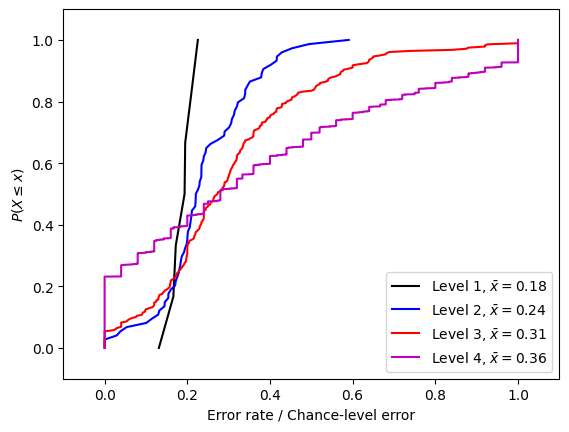

In [241]:
# Plot accuracy
measure = rel_err_arr
xlabel = 'Error rate / Chance-level error' # Error rate | Error rate / Chance-level error | Accuracy
ep = 1e-1
fig, ax = plt.subplots( )
colors = ['k', 'b', 'r', 'm']
linestyles = ['-', '-', '-', '-']

for i, elt in enumerate(measure):
    x = np.sort(elt)
    y = np.arange(len(x)) / (len(x) - 1)
    ax.plot(x, y, color=colors[i], label=f"Level {i+1}, " + r'$\bar{x}=$' + f"{x.mean():.2f}", ls=linestyles[i])

ax.set_ylabel(r'$P(X \leq x)$')
ax.set_xlabel(xlabel)
ax.set_ylim(-ep, 1 + ep)
ax.set_xlim(- ep, 1 + ep)
ax.legend()
plt.show()

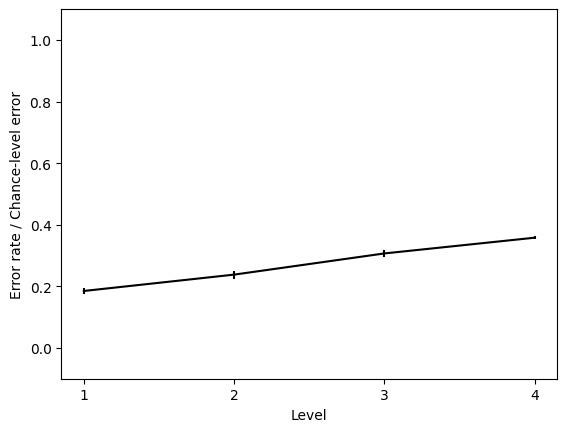

In [243]:
level_arr = np.arange(1, n_levels+1)
mean_measure = [np.array(elt).mean() for elt in measure]
sem_measure = [np.array(elt).std() / np.sqrt(len(elt)) for elt in measure]

fig, ax = plt.subplots()
ax.errorbar(level_arr, mean_measure, yerr=sem_measure, color='k')
ax.set_ylabel(xlabel)
ax.set_xlabel('Level')
ax.set_ylim(-ep, 1 + ep)
ax.set_xticks(level_arr)
plt.show()

In [235]:
nth_level_errors = []
for j in range(n_levels):
    n_errors = 0
    for k in unique_ec_tups[j]:
        if k in total:
            n_errors += total[k] * (1 - accuracy[k])

    print(n_errors)
    nth_level_errors.append(n_errors)


errors_at = [nth_level_errors[0]]
for i in range(len(nth_level_errors) - 1):
    errors_at.append(nth_level_errors[i+1] - nth_level_errors[i])

errors_at

15009.0
21723.0
25788.0
44710.0


[15009.0, 6714.0, 4065.0, 18922.0]

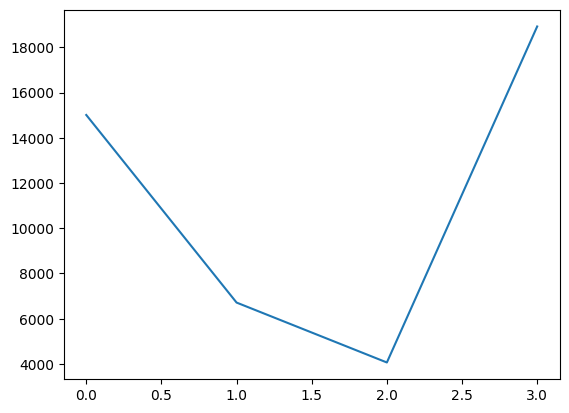

In [245]:
fig, ax = plt.subplots()
ax.plot(errors_at)

In [244]:
set(total.keys()) ^ set(accuracy.keys())

set()

In [157]:
xs = np.array([1,3,4])
gt_var = xs.var()
gt_mean = xs.mean()
d = lambda x,y : (x - y)**2
xq = 7
print(d(gt_mean, xq) - d(xs, xq).mean())
print(gt_var)

-1.55555555555555
1.5555555555555554
